# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [1]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PolynomialFeatures, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, roc_curve, roc_auc_score, classification_report, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import make_scorer, recall_score



import warnings
from sklearn import set_config
set_config(display='diagram')



In [2]:
P_flag = False # controls print statements in this notebook.

In [3]:
os.makedirs('logs', exist_ok=True)
os.makedirs('images', exist_ok=True)

In [4]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [5]:
df.head()

age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0          93.994          -36.4      4.857       5191.0  no  
1          93.994          -36.4      4.857       5191.0  no  
2          93.994          -36.4      4.857       5191.0  no  
3          93.994          -36.4      4.857       5191.0  no  
4          93.994          -36.4      4.857       5191.0  no  

[5 rows x 21 columns]

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [7]:
print (df.isnull().sum())
print(df.shape)


age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64
(41188, 21)


In [8]:
df = df.drop(columns=['duration'])
df.shape

(41188, 20)

In [9]:
categorical_cols = df.select_dtypes(include=['object']).columns.to_list()
for col in categorical_cols :
    unique_values = df[col].unique()
    print(f" Unique values in {col} : {len(unique_values)}  : {unique_values} \n")
categorical_cols.remove('y')
print(f" Categrorical columns :  {len(categorical_cols)} : {categorical_cols}")

 Unique values in job : 12  : ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student'] 

 Unique values in marital : 4  : ['married' 'single' 'divorced' 'unknown'] 

 Unique values in education : 8  : ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate'] 

 Unique values in default : 3  : ['no' 'unknown' 'yes'] 

 Unique values in housing : 3  : ['no' 'yes' 'unknown'] 

 Unique values in loan : 3  : ['no' 'yes' 'unknown'] 

 Unique values in contact : 2  : ['telephone' 'cellular'] 

 Unique values in month : 10  : ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep'] 

 Unique values in day_of_week : 5  : ['mon' 'tue' 'wed' 'thu' 'fri'] 

 Unique values in poutcome : 3  : ['nonexistent' 'failure' 'success'] 

 Unique values in y : 2  : ['no' 'yes'] 

 Categrorical columns :  10 : ['job', 'marital', 'education', 'default', 'hou

In [10]:
#Getting ststical distribution by using describe()
df.describe()

age      campaign         pdays      previous  emp.var.rate  \
count  41188.00000  41188.000000  41188.000000  41188.000000  41188.000000   
mean      40.02406      2.567593    962.475454      0.172963      0.081886   
std       10.42125      2.770014    186.910907      0.494901      1.570960   
min       17.00000      1.000000      0.000000      0.000000     -3.400000   
25%       32.00000      1.000000    999.000000      0.000000     -1.800000   
50%       38.00000      2.000000    999.000000      0.000000      1.100000   
75%       47.00000      3.000000    999.000000      0.000000      1.400000   
max       98.00000     56.000000    999.000000      7.000000      1.400000   

       cons.price.idx  cons.conf.idx     euribor3m   nr.employed  
count    41188.000000   41188.000000  41188.000000  41188.000000  
mean        93.575664     -40.502600      3.621291   5167.035911  
std          0.578840       4.628198      1.734447     72.251528  
min         92.201000     -50.800000      0.634000   4963.600000  
25%         93.075000     -42.700000      1.344000   5099.100000  
50%         93.749000     -41.800000      4.857000   5191.000000  
75%         93.994000     -36.400000      4.961000   5228.100000  
max         94.767000     -26.900000      5.045000   5228.100000

Text(0.5, 1.0, 'Marketing Campaing Success Rate Distribution')

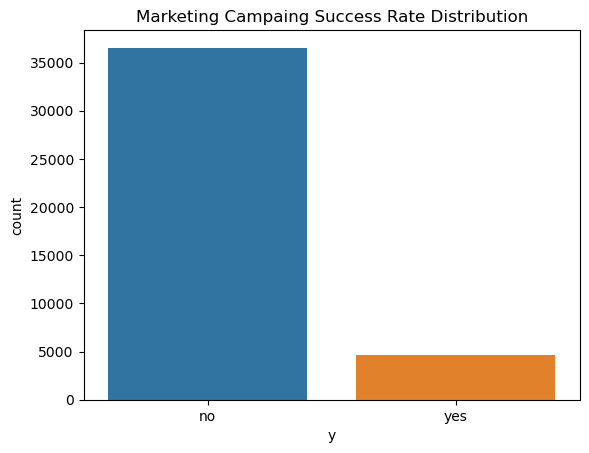

In [11]:
# Checking if data is balanced
sns.countplot(data=df, x ='y', hue='y')
plt.title('Marketing Campaing Success Rate Distribution')

### Problem 6: Train/Test Split, Encoding and Scalling

With your data prepared, split it into a train and test set.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('y', axis=1), df['y'], random_state=42, stratify=df.y, test_size=0.2)

print(f" \nChecking if Target is properly distributed among train and test splits \n")

print (f" y_train value counts : { y_train.value_counts(normalize=True)}")
print (f" y_test value counts : { y_test.value_counts(normalize=True)}")

 
Checking if Target is properly distributed among train and test splits 

 y_train value counts : y
no     0.887344
yes    0.112656
Name: proportion, dtype: float64
 y_test value counts : y
no     0.887351
yes    0.112649
Name: proportion, dtype: float64


In [13]:
transformer = make_column_transformer((OneHotEncoder(drop='if_binary'), categorical_cols), remainder=StandardScaler())
#transformer = ColumnTransformer(transformers= [('cat' , OneHotEncoder(drop='if_binary'), categorical_cols), ('num', StandardScaler())


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

Using Dummy Classified with "Stratified" to get baseline model score

Description: This model makes predictions based on the distribution of classes in the training data. For instance, if 70% of your training data belongs to class A and 30% to class B, this model will randomly predict class A 70% of the time and class B 30% of the time.

In [14]:
baseline_pipe = Pipeline([('transform', transformer),
                          ('dummy_strat' , DummyClassifier(strategy='stratified', random_state=42))])


In [15]:
%%time
baseline_pipe.fit(X_train,y_train)


CPU times: user 223 ms, sys: 193 ms, total: 416 ms
Wall time: 86 ms


Pipeline(steps=[('transform',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome'])])),
                ('dummy_strat',
                 DummyClassifier(random_state=42, strategy='stratified'))])

In [16]:
print(f" Baseline Accuracy Score (Stratified) : { accuracy_score(y_test, baseline_pipe.predict(X_test)) : .4f}")

 Baseline Accuracy Score (Stratified) :  0.8037


### Problem 10: Model Comparisons 


Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|  Base  | 0.072s   |.   8037  |.   NA  |
|  Logistic Regrssion  | 0.28s   |.   8999  |.   9008  |
|  KNN  | 0.085s   |.   9123  |.  8961   |
|  Decision Tree  | 0.223s   |.   9954  |.   8450  |
|  Support Vector Machine(SVM)  | 41.68s   |.   9049  |.   9035  |

In [17]:
%%time
def eval_mdl(model, X_tr, y_tr, X_te, y_te, m_name,output_file):
    print(f"Running model : {m_name}\n")
    outlog = 'logs/' + output_file + 'default_log.txt'
    imagelog = 'images/' + output_file
    with open(outlog, 'a') as f:
        f.write (f"Running model :  {m_name}\n")

    model_pipe = Pipeline([('transform', transformer),('m_classfier', model)])
    start_time = time.time()
    model_pipe.fit(X_tr, y_tr)
    end_time = time.time()
    fit_time = end_time - start_time
    
    train_accuracy = accuracy_score(y_tr, model_pipe.predict(X_tr))
    test_accuracy = accuracy_score(y_te, model_pipe.predict(X_te))

    m_preds = model_pipe.predict(X_te)
    m_precision = precision_score(y_te, m_preds, pos_label='yes')
    m_recall = recall_score(y_te, m_preds, pos_label='yes')
    m_f1 = f1_score(y_te, m_preds, pos_label='yes')

    m_proba = model_pipe.predict_proba(X_te)[:,list(model_pipe.classes_).index('yes')]
    m_auc = roc_auc_score(y_te, m_proba)
    

    model_confusion_matrix = confusion_matrix(y_te, model_pipe.predict(X_te), labels=['no', 'yes'])
    with open(outlog, 'a') as f:
        f.write(f" {m_name} fit time : {fit_time:.4f}, Training Accuracy : {train_accuracy: .4f}, Test Accuracy: {test_accuracy:.4f}\n")
        f.write(f"{m_name} Classification report : \n {classification_report(y_te, model_pipe.predict(X_te) )}\n")
        f.write(f"{m_name} Confusion Matrix : \n {model_confusion_matrix}\n")

    if P_flag:
        print(f" {m_name} fit time : {fit_time:.4f}, Training Accuracy : {train_accuracy: .4f}, Test Accuracy: {test_accuracy:.4f}")
        print(f"{m_name} Classification report : \n {classification_report(y_te, model_pipe.predict(X_te) )}")
        print(f"{m_name} Confusion Matrix : \n {model_confusion_matrix}")
    disp = ConfusionMatrixDisplay(model_confusion_matrix, display_labels=['no','yes'])
    disp.plot()
    plt.title(m_name + "_confusion_matrix")
    plt.savefig(f'{imagelog}_{m_name}_default_confusion_matrix.png')

    if P_flag:
        plt.show()
    plt.close()
    results_dict = {
        'Model' : m_name,
        'Fit_Time(sec)' : np.round(fit_time,3),
        'Train_accuracy' : np.round(train_accuracy, 3),
        'Test_accuracy' : np.round(test_accuracy, 3),
        'Precision' : np.round(m_precision,3),
        'Recall' : np.round(m_recall,3),
        'F1-Score' : np.round(m_f1,3),
        'ROC_AUC_Score' : np.round(m_auc,3),
    }
    return results_dict, outlog 


CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 8.82 µs


In [18]:
models = {
    'Logreg' : LogisticRegression(random_state=42),
    'knn' : KNeighborsClassifier(),
    'dtree' : DecisionTreeClassifier(random_state=42),
    'svm' : SVC(random_state=42, probability=True)
}
m_results ={}
for name, model in models.items():
    m_results[name], output_file =eval_mdl(model, X_train, y_train, X_test, y_test, name, 'Accuracy')
m_results_df= pd.DataFrame(m_results).transpose().reset_index(drop=True)
with open(output_file, 'a') as f:
    f.write(f"\nSummary Table: \n")
    f.write(m_results_df.to_string())


Running model : Logreg

Running model : knn

Running model : dtree

Running model : svm



In [19]:
m_results_df

Model Fit_Time(sec) Train_accuracy Test_accuracy Precision Recall  \
0  Logreg         0.322            0.9         0.901     0.688  0.219   
1     knn          0.07          0.912         0.896     0.576  0.294   
2   dtree         0.226          0.995         0.845     0.324  0.345   
3     svm       212.284          0.905         0.903     0.708  0.244   

  F1-Score ROC_AUC_Score  
0    0.332         0.801  
1    0.389         0.741  
2    0.334         0.628  
3    0.362         0.702

In [20]:
# def fit_time_plot(df_F):
#     sns.barplot(data=df_F, x='Model', y='Fit_Time(sec)', hue='Model')
#     plt.title("Fit time by Model")
#     plt.grid(which='major', axis='y')

In [21]:
def fit_time_plot(df_F, use_log_scale=False):
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_F, x='Model', y='Fit_Time(sec)', hue='Model')
    
    plt.title("Fit time by Model")
    plt.grid(which='major', axis='y')
    
    if use_log_scale:
        plt.yscale('log')  # Apply log scale to y-axis if specified
        plt.title("Fit time by Model (Log Scale)")
    
    # Annotate the bars with the exact fit time values
    for index, row in df_F.iterrows():
        plt.text(index, row['Fit_Time(sec)'], f"{row['Fit_Time(sec)']:.2f}", color='black', ha="center", va="bottom")

    plt.show()

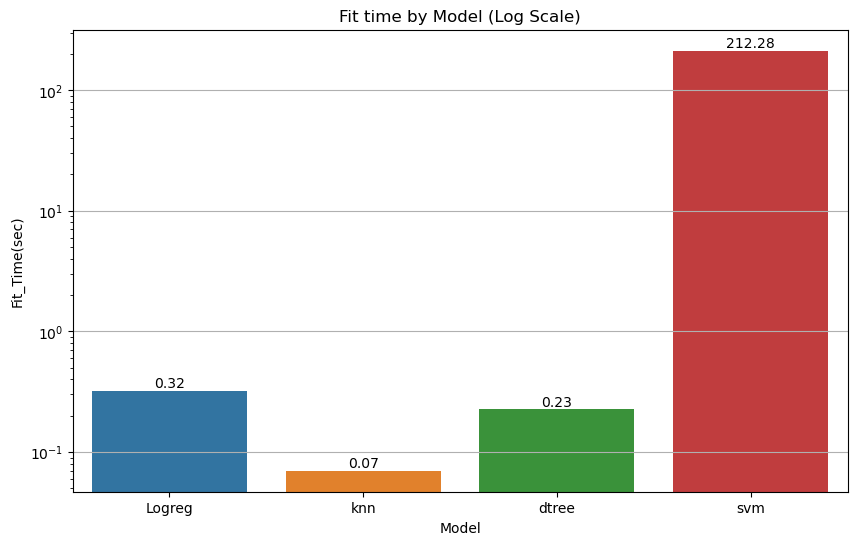

In [22]:
fit_time_plot(m_results_df, True)

In [23]:
def score_plot(df_sf):
    # List of metrics to plot
    metrics = ['Train_accuracy', 'Test_accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC_AUC_Score']

    # Create a figure and axis
    plt.figure(figsize=(10, 6))

    # Plot each metric
    for metric in metrics:
        plt.plot(df_sf['Model'], df_sf[metric], marker='o', label=metric)

    # Add labels and title
    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.title('Comparison of Different Scoring Metrics')
    plt.xticks(rotation=45)

    # Add a legend
    plt.legend(title='Metric')

    # Show the plot
    plt.show()

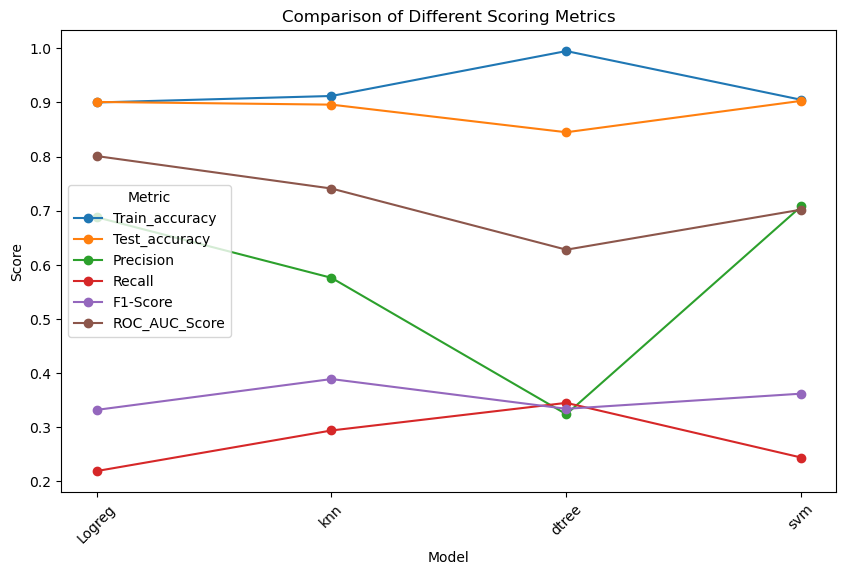

In [24]:
score_plot(m_results_df)

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [25]:
numeric_columns = df.select_dtypes(include=['int64','float64']).columns.to_list()
print(numeric_columns)

['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


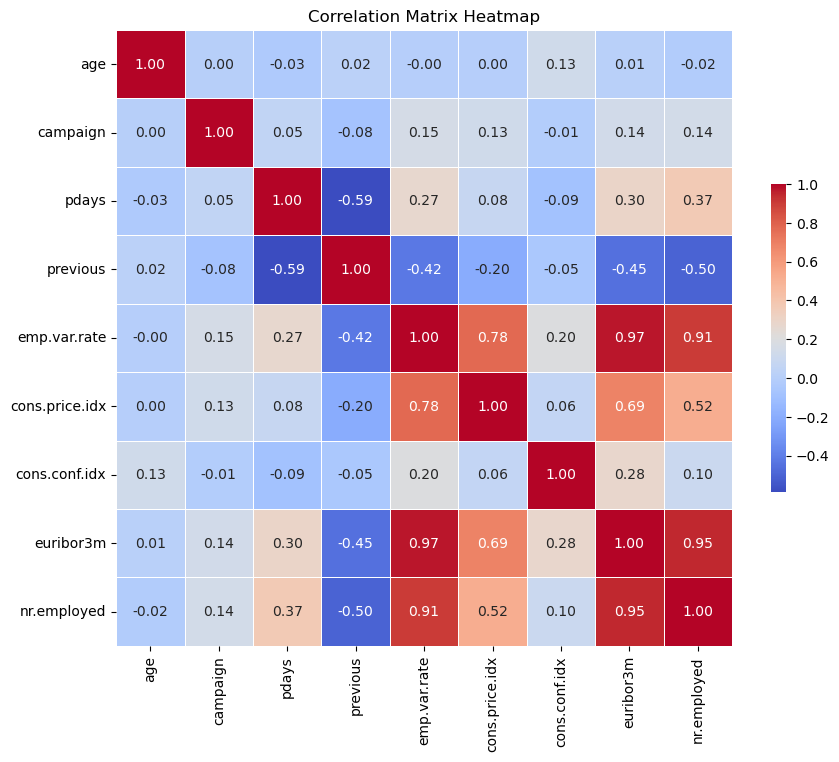

In [26]:
correlation_matrix = df[numeric_columns].corr()

plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Matrix Heatmap')
plt.show()

	1.	Highly Correlated Features:
	•	emp.var.rate and euribor3m have a very high correlation (r = 0.97).
	•	emp.var.rate and nr.employed also have a very high correlation (r = 0.91).
	•	euribor3m and nr.employed are highly correlated (r = 0.95).

In [27]:
#dropping emp.var.rate
df.drop(columns=['emp.var.rate','euribor3m'], inplace=True)
numeric_columns = df.select_dtypes(include=['int64','float64']).columns.to_list()


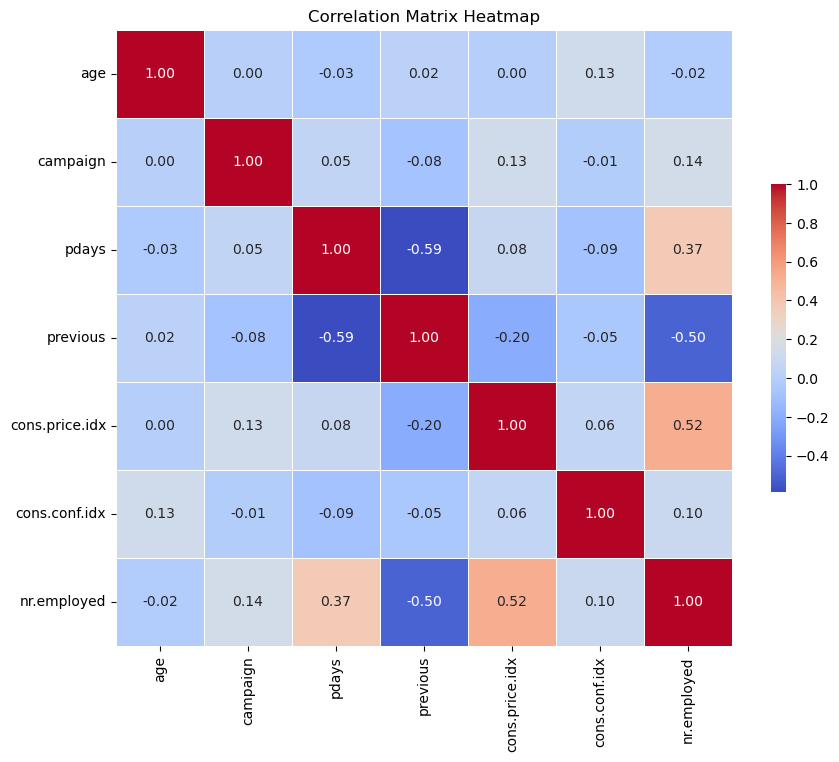

In [28]:
correlation_matrix = df[numeric_columns].corr()

plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Matrix Heatmap')
plt.show()

### using SFS to reduce featurs


In [29]:
# Define the pipeline
# pipeline = Pipeline(steps=[
#     ('transform', transformer),
#     ('classifier', LogisticRegression())
# ])
# pipeline.fit(X_train, y_train)
# # Apply Sequential Feature Selector (SFS)
recall_scorer = make_scorer(recall_score, pos_label = 'yes')


sfs = SequentialFeatureSelector(
    estimator=LogisticRegression(max_iter=1000),  # the model after preprocessing
    n_features_to_select=10,  # number of features to select, adjust as necessary
    direction='forward',     # forward selection, could also use 'backward'
    # scoring=recall_scorer,      # scoring metric, adjust as necessary
    # scoring='accuracy',      # scoring metric, adjust as necessary
    scoring='accuracy',      # scoring metric, adjust as necessary
    cv=5                     # cross-validation strategy
)

# Fit the SFS on the preprocessed data
X_train_transformed = transformer.fit_transform(X_train)
# X_test_transformed = transformer.fit_transform(X_test)
sfs.fit(X_train_transformed, y_train)

# Selected features
selected_features = sfs.get_support(indices=True)
print("Selected features:", selected_features)

Selected features: [ 0 13 17 20 27 29 34 41 54 60]


In [30]:
X_test_transformed = transformer.transform(X_test)


In [31]:
feature_names = transformer.get_feature_names_out()
# print(feature_names)
selected_feature_names = feature_names[selected_features]
# print("Selected feature names:", selected_feature_names)


In [32]:
X_train_selected = X_train_transformed[:,selected_features]
X_test_selected = X_test_transformed[:,selected_features]


In [33]:
param_grid =  {
    # 'Logreg' :  {'Logreg__C' : [0.1,1,10,100],
    #           'Logreg__max_iter' : [5000],
    #           "Logreg__penalty": ["l1", "l2", "elasticnet", none],
    #           "Logreg__solver": ["liblinear", "saga"],
    #         #   "Logreg__solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
    #           },
    'Logreg': {
        # 'Logreg__C': [0.01, 0.1, 1, 10, 100],
        'Logreg__C': [0.01, 0.1, 1, 10, 100],
        'Logreg__max_iter': [200,300,500],
        'Logreg__penalty': ['l1', 'l2'],
        'Logreg__solver': ['liblinear'],
    },
    'Logreg_others': {
        # 'Logreg_others__C': [0.1, 1, 10, 100],
        'Logreg_others__max_iter': [5000],
        # 'Logreg_others__penalty': ['l2', None],
        'Logreg_others__penalty': [None],
        'Logreg_others__solver': ['newton-cg', 'lbfgs', 'sag'],
    },
    'Logreg_saga': {
        # 'Logreg_saga__C': [0.1, 1, 10, 100],
        'Logreg_saga__C': [0.1, 1],
        'Logreg_saga__max_iter': [1000],
        'Logreg_saga__penalty': ['elasticnet'],
        'Logreg_saga__solver': ['saga'],
        # 'Logreg_saga__l1_ratio': [0.1, 0.5, 0.7, 0.9],  # Add l1_ratio for elasticnet
        'Logreg_saga__l1_ratio': [0.7, 0.9],  # Add l1_ratio for elasticnet
    },
    'knn' : {'knn__n_neighbors' : range(15,23,2),
              'knn__weights' : ['uniform','distance'], 
            #   "knn__algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
              'knn__p': [1,2]
              },
    'dtree' : {'dtree__max_depth' : np.arange(4,10,2),
                'dtree__min_samples_split' : [2,4,6],
                'dtree__criterion' : ['gini', 'entropy'],
                'dtree__min_samples_leaf' : [15,20,25]},
    # 'svm' : {'svm__kernel' : ['rbf', 'poly','linear','sigmoid'],
    #           'svm__C' : [0.1, 1, 10, 100],
    #           'svm__gamma' : [0.1,1, 10, 100] }
    'svm_rbf' : {'svm_rbf__kernel' : ['rbf'],
              'svm_rbf__C' : [0.1, 1,10,100 ],
              'svm_rbf__gamma' : [0.01,0.1,1,10] },
    'svm_linear' : {'svm_linear__kernel' : ['linear'],
              'svm_linear__C' : [0.1, 1 ]},
    'svm_poly' : {'svm_poly__kernel' : ['poly'],
              'svm_poly__C' : [0.1, 1 ],
              'svm_poly__gamma' : [0.1,1],
               'svm_poly__degree' : [2,3] }
              
}

In [34]:
def eval_optimized_mdl(model, X_tr, y_tr, X_te, y_te, m_name,p_grid, p_dict, output_file):
    # model_pipe = Pipeline([('transform', transformer),
    #                         ('feature_selection', SequentialFeatureSelector(
    #                             estimator=LogisticRegression(max_iter=1000),
    #                             n_features_to_select=5,
    #                             direction='forward',
    #                             scoring='accuracy',
    #                             cv=5
    #                             )),
    #                        (m_name, model)])
    print(f"Running model : {m_name}\n")
    outlog = 'logs/' + output_file + 'Grid_log.txt'
    imagelog = 'images/' + output_file
    with open(outlog, 'a') as f:
        f.write (f"Running model :  {m_name}\n")
    
    model_pipe = Pipeline([(m_name, model)])
    model_grid = GridSearchCV(model_pipe, p_grid[m_name],cv=5, refit=True, scoring='accuracy', verbose=1)
    # model_grid = GridSearchCV(model_pipe, p_grid[m_name],cv=5, refit=True, scoring=recall_scorer, verbose=1)
    start_time = time.time()
    model_grid.fit(X_tr, y_tr)
    end_time = time.time()
    fit_time = end_time - start_time

    train_accuracy = accuracy_score(y_tr, model_grid.best_estimator_.predict(X_tr))
    test_accuracy = accuracy_score(y_te, model_grid.best_estimator_.predict(X_te))

    m_preds = model_grid.best_estimator_.predict(X_te)
    m_precision = precision_score(y_te, m_preds, pos_label='yes')
    m_recall = recall_score(y_te, m_preds, pos_label='yes')
    m_f1 = f1_score(y_te, m_preds, pos_label='yes')

    m_proba = model_grid.best_estimator_.predict_proba(X_te)[:,list(model_grid.best_estimator_.classes_).index('yes')]
    m_auc = roc_auc_score(y_te, m_proba)

    p_dict[str(m_name)] = model_grid.best_estimator_.predict_proba(X_te)[:, list(model_grid.best_estimator_.classes_).index('yes')]
    model_confusion_matrix = confusion_matrix(y_te, m_preds, labels=['no', 'yes'])
    with open(outlog, 'a') as f :
        f.write(f" {m_name} fit time : {fit_time:.4f}, Training Accuracy : {train_accuracy: .4f}, Test Accuracy: {test_accuracy:.4f}\n")
        f.write(f" {m_name} best_params : { model_grid.best_params_}\n")
        f.write(f"{m_name} Classification report : \n {classification_report(y_te, m_preds )}\n")
        f.write(f"{m_name} Confusion Matrix : \n {model_confusion_matrix}\n")

    if P_flag:
        print(f" {m_name} fit time : {fit_time:.4f}, Training Accuracy : {train_accuracy: .4f}, Test Accuracy: {test_accuracy:.4f}")
        print(f" {m_name} best_params : { model_grid.best_params_}")
        print(f"{m_name} Classification report : \n {classification_report(y_te, m_preds )}")
        print(f"{m_name} Confusion Matrix : \n {model_confusion_matrix}")
    
    disp = ConfusionMatrixDisplay(model_confusion_matrix, display_labels=['no','yes'])
    disp.plot()
    plt.title(m_name + "_confusion_matrix")
    plt.savefig(f'{imagelog}_{m_name}_Grid_confusion_matrix.png')
    if P_flag:
        plt.show()
    plt.close()
    results_dict = {
        'Model' : m_name,
        'Fit_Time(sec)' : np.round(fit_time,3),
        'Train_accuracy' : np.round(train_accuracy, 3),
        'Test_accuracy' : np.round(test_accuracy, 3),
        'Precision' : np.round(m_precision,3),
        'Recall' : np.round(m_recall,3),
        'F1-Score' : np.round(m_f1,3),
        'ROC_AUC_Score' : np.round(m_auc,3),
    }
    return results_dict, outlog 


In [35]:
models = {
    'Logreg' : LogisticRegression(random_state=42),
    'Logreg_others' : LogisticRegression(random_state=42),
    'Logreg_saga' : LogisticRegression(random_state=42),
    'knn' : KNeighborsClassifier(),
    'dtree' : DecisionTreeClassifier(random_state=42),
    'svm_rbf' : SVC(random_state=42, probability=True),
    'svm_linear' : SVC(random_state=42, probability=True),
    # 'svm_poly' : SVC(random_state=42)
}
proba_dict = {}
m_opt_results ={}

for name, model in models.items():
    m_opt_results[name], output_file = eval_optimized_mdl(model, X_train_selected, y_train, X_test_selected, y_test, name, param_grid, proba_dict, 'Accuracy_10fwd')

m_opt_results_df = pd.DataFrame(m_opt_results).transpose().reset_index(drop=True)
with open(output_file, 'a') as f:
    f.write(f"\nSummary Table: \n")
    f.write(m_opt_results_df.to_string())

    # eval_optimized_mdl(model, X_train, y_train, X_test, y_test, name, param_grid)

Running model : Logreg

Fitting 5 folds for each of 30 candidates, totalling 150 fits


Running model : Logreg_others

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Running model : Logreg_saga

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Running model : knn

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Running model : dtree

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Running model : svm_rbf

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Running model : svm_linear

Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [36]:
m_opt_results_df

Model Fit_Time(sec) Train_accuracy Test_accuracy Precision Recall  \
0         Logreg       491.032            0.9           0.9     0.724  0.178   
1  Logreg_others         6.954            0.9           0.9     0.724  0.178   
2    Logreg_saga         4.392            0.9           0.9     0.724  0.178   
3            knn        21.252          0.899         0.898     0.633  0.228   
4          dtree         7.269          0.899           0.9     0.726  0.183   
5        svm_rbf      2410.784            0.9         0.899     0.734  0.169   
6     svm_linear       421.412          0.897         0.898     0.647  0.202   

  F1-Score ROC_AUC_Score  
0    0.285         0.775  
1    0.285         0.775  
2    0.285         0.775  
3    0.336         0.765  
4    0.293         0.786  
5    0.275         0.604  
6    0.307         0.761

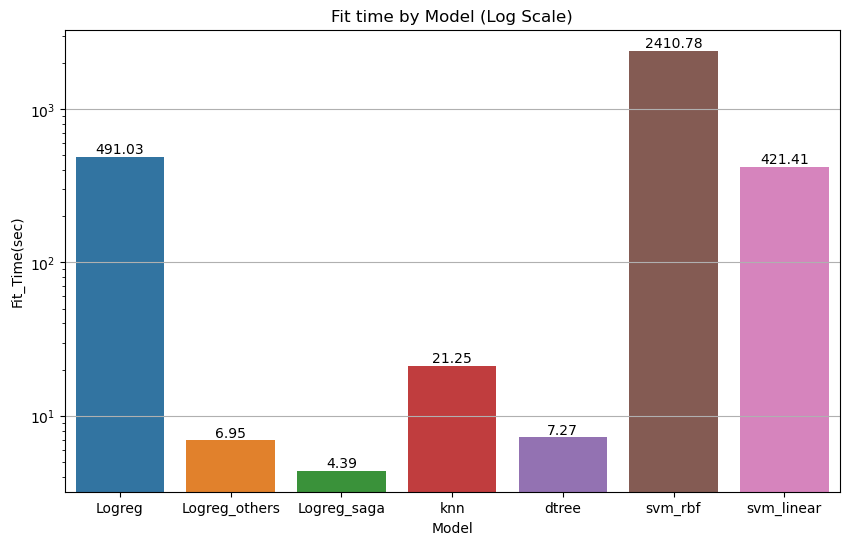

In [37]:
fit_time_plot(m_opt_results_df, True)

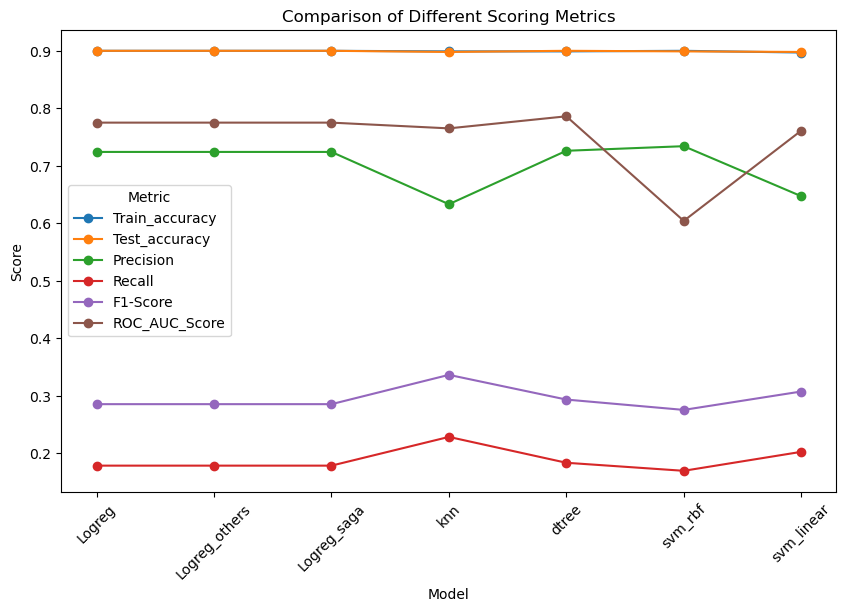

In [38]:
score_plot(m_opt_results_df)

### ROC Curve


In [39]:
labels = {
    'Logreg' :'LogReg Norm',
    'Logreg_others' : 'LogReg Others',
    'Logreg_saga' : 'LogReg Saga',
    'knn' : 'KNN',
    'dtree' : 'Decision Tree',
    'svm_rbf' : 'SVM RBF',
    'svm_linear' : 'SVM Linear',
    # 'svm_poly' : 'SVM Poly'
}

colors = {
    'Logreg': 'darkorange',
    'Logreg_others': 'darkblue',
    'Logreg_saga': 'magenta',
    'knn': 'purple',
    'dtree': 'darkcyan',
    'svm_rbf': 'crimson',
    'svm_linear': 'seagreen',
    'svm_poly': 'goldenrod'
}


In [40]:
def plot_roc_curves(proba_dict, y_test, labels, colors):
    plt.figure()
    
    for model_name, probs in proba_dict.items():
        #fpr, tpr, _ = roc_curve(y_test, probs[:, 1], pos_label='yes')
        #fpr, tpr, _ = roc_curve(y_test, probs[:, 1], pos_label='yes')
        fpr, tpr, _ = roc_curve(y_test, probs, pos_label='yes')
        # auc = roc_auc_score(y_test, probs[:, 1])
        auc = roc_auc_score(y_test, probs)
        color = colors.get(model_name, 'black')  # Default color is black if not provided
        plt.plot(fpr, tpr, color=color, lw=2, label=f'{labels[model_name]} ROC curve (area = {auc:.2f})')
    
    # Plot the diagonal line representing random guessing
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig('images/ROC_curve_AC10FWD.png')
    plt.show()
    plt.close()

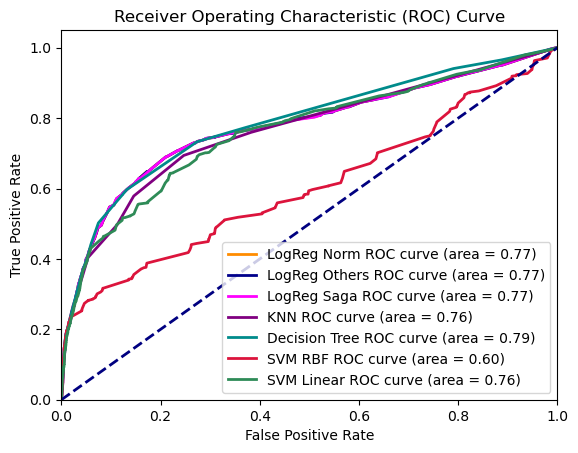

In [41]:
plot_roc_curves(proba_dict, y_test, labels, colors)


# Model Performance Summary

This summary provides insights into the performance and efficiency of various machine learning models applied to the dataset.

## 1. ROC Curve Analysis
- **Logistic Regression (LogReg)** models (`Norm`, `Others`, `Saga`) show consistent performance with an ROC AUC of **0.77**.
- **K-Nearest Neighbors (KNN)** and **SVM Linear** both have slightly lower ROC AUC scores around **0.76**.
- **Decision Tree** (Dtree) performed slightly better than KNN and SVM Linear with an ROC AUC of **0.79**.
- **SVM with RBF kernel** has the lowest ROC AUC at **0.60**, indicating that this model struggled the most with the classification task.

## 2. Comparison of Scoring Metrics
- **Training and Testing Accuracy:** 
  - All models show high training accuracy, but testing accuracy is lower, indicating potential overfitting, especially for models like Decision Tree and SVM.
- **Precision:** 
  - Precision varies across models, with **Logistic Regression** models showing higher precision compared to other models.
- **Recall and F1-Score:** 
  - Recall is relatively low across the board, particularly for SVM RBF and Logistic Regression, indicating that these models might not be catching as many true positives.
- **ROC AUC:** 
  - The ROC AUC scores show that Decision Tree and Logistic Regression models are generally better at distinguishing between classes.

## 3. Model Training Time
- **SVM with RBF kernel** took the longest time to train by far (~**2410 seconds**), followed by **SVM Linear** (~**421 seconds**).
- **Logistic Regression (Norm)** also had a significant training time (~**491 seconds**).
- **KNN, Decision Tree, and other Logistic Regression models** trained much faster, with times ranging from **4 to 21 seconds**.

## Conclusion
- **Logistic Regression** models generally perform well in terms of both accuracy and ROC AUC, with reasonable training times, making them a solid choice for this dataset.
- **Decision Tree** has good ROC AUC but shows signs of overfitting, as indicated by the high training accuracy but lower test accuracy.
- **SVM with RBF kernel**, while powerful in some scenarios, is not performing well here, with low ROC AUC and very high training time.
- **KNN and SVM Linear** offer moderate performance but are relatively efficient in terms of training time.

For practical purposes, Logistic Regression models seem to be the most balanced in terms of performance and efficiency. SVM RBF might not be the best choice given the long training time and lower predictive performance.

In [60]:
logreg_best = LogisticRegression(C=1, max_iter=200, penalty='l2',solver='liblinear').fit(X_train_selected,y_train)
logreg_best_coeffs = logreg_best.coef_[0]
features = []
for i in selected_feature_names:
    features.append(i.split('__')[1])
print(features)
coeff_df = pd.DataFrame({
    'Feature' : features,
    'Coefficient' : logreg_best_coeffs
})
coeff_df = coeff_df.reindex(coeff_df.Coefficient.abs().sort_values(ascending=False).index)
coeff_df

['job_admin.', 'marital_married', 'education_basic.6y', 'education_illiterate', 'housing_no', 'housing_yes', 'month_apr', 'month_nov', 'pdays', 'nr.employed']


Feature  Coefficient
9           nr.employed    -0.780631
3  education_illiterate     0.654837
8                 pdays    -0.294682
6             month_apr     0.204442
0            job_admin.     0.117931
1       marital_married    -0.093147
5           housing_yes    -0.080183
2    education_basic.6y    -0.074522
7             month_nov    -0.047672
4            housing_no    -0.038075

Text(0.5, 1.0, 'Feature Coefficients from Logistic Regression')

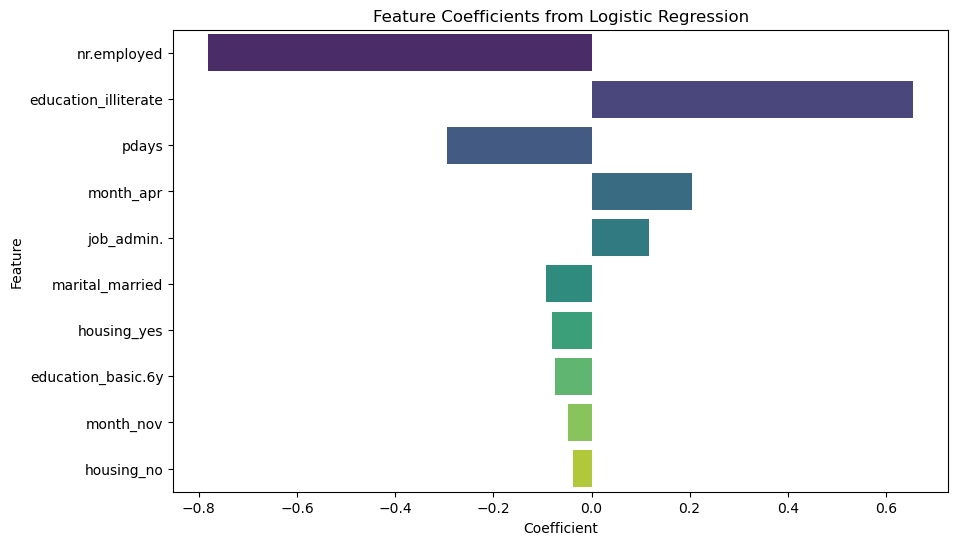

In [63]:
plt.figure(figsize=(10,6))
sns.barplot(data=coeff_df, x='Coefficient', y='Feature', palette='viridis', hue='Feature')
plt.title("Feature Coefficients from Logistic Regression")

##### Questions